## Objective
- Use the images from MNIST along with a random number (integer) generated between 0 to 9 as input and return as outputs the predicted digit (predictions on the image) along with the sum of the values, i.e. Predicted digit from MNIST + Generated Random Integer.

## Imports

In [1]:
# PyTorch, everything from PyTorch can be referred with this
import torch

# Import the neural network model seperately
import torch.nn as nn

# Contains functions that are required such as ReLu (Activation function)
import torch.nn.functional as F 

# Optimizers required to converge using Backpropogation
import torch.optim as optim

# Datasets are used to download and load the data
# used to train and validate
# Transforms can be used to define modifications and/or augmentations methods
# to be applied while passing the data
# Normalization can also be one of the compositions of transforms
import torchvision
from torchvision import datasets, transforms

# Dataset abstract class using which custom dataset classes can be created
# DataLoader to create batches and to shuffle the data
from torch.utils.data import Dataset, DataLoader

# Visualize the images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid # ImageGrid to form a grid of images

## Load the dataset
Define a class a that loads and takes the images from MNIST and generates a random number (between 0-9) to use as input along with the actual label of the handwritten digit and the sum, which constitutes the required output

In [2]:
class SumDataset (Dataset):
    ''' Extending the Dataset class to provide customized inputs and modified 
    outputs for training '''

    def __init__(self, mode='training'):
        ''' Get/Download the data (MNIST) and setup up other configurations
        required to get the data
        
        Parameters:
            mode - Indicates either 'training' or 'validation'
        '''

        # Start by initializing the base class
        super().__init__()

        # Save the mode
        # Check if the mode is valid
        assert mode in ['training', 'validation'], \
            '"mode" should be either "training" or "validation"'
        self.mode = mode

        # Seed the random generator to results that are reproduceable
        # Remove during production
        torch.manual_seed(1)

        # Get MNIST data
        if self.mode == 'training':        
            # Define the transformations
            #   First convert into a tensor and then normalization
            #   Values for normalization where got from 
            #   https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
            self.transforms = transforms.Compose ([transforms.ToTensor (),
                                                   transforms.Normalize((0.1307,), 
                                                                        (0.3081,))])
        
            # Download the training set and store it at the root directory
            self.data = datasets.MNIST (root='./data/train/',
                                               train=True,
                                               download=True,
                                               transform=self.transforms)
            
        elif self.mode == 'validation':
            # Both the train and validation transforms are the same, but might decide 
            # to update with some data augmentation methods for train later
            # so keeping it seperate
            self.transforms = transforms.Compose ([transforms.ToTensor (),
                                                   transforms.Normalize((0.1307,), 
                                                                        (0.3081,))])
            
            # Get the validation set
            self.data = datasets.MNIST (root='./data/val/',
                                                  train=False,
                                                  download=True,
                                                  transform=self.transforms)
        

    def __len__(self):
        ''' Get the total size of the dataset '''
        return len (self.data)


    def __getitem__(self, index):
        ''' Used to get the index-th item from the dataset 
        
        Parameters:
            index - Element value to retrieve from the data
        '''

        # Check if the within the bounds of the data
        assert index < len (self.data), 'The index value is out-of-bound'

        # Index into the data to get the image and the corresponding label
        img, label = self.data [index]

        # Generate a random integer between 0 to 9
        randint_input = torch.randint (low=0, high=10, size=(1,)) [0]

        # For the outputs, the labels of MNIST and the final sum are one-hot
        # encoded seperately (the number of classes for the sum would be 18=9+9+1)
        # i.e. 0-18 (inclusive)
        # And also one_hot encode the random integer
        sum = F.one_hot (torch.as_tensor ([label+randint_input]), 
                         num_classes=9+9+1)
        label = F.one_hot (torch.as_tensor ([label]), num_classes=10)
        randint_input = F.one_hot (torch.as_tensor ([randint_input]), num_classes=10)

        # Return the training set and the corresponding one-hot encoded outputs
        return img, randint_input, label, sum

### Visualize the samples

In [3]:
# Define an object of the class 
# Set the "mode" to training
sum_dataset = SumDataset (mode='training')


Extracting ./data/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/train/MNIST/raw




Extracting ./data/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/MNIST/raw




Extracting ./data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/MNIST/raw




Extracting ./data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


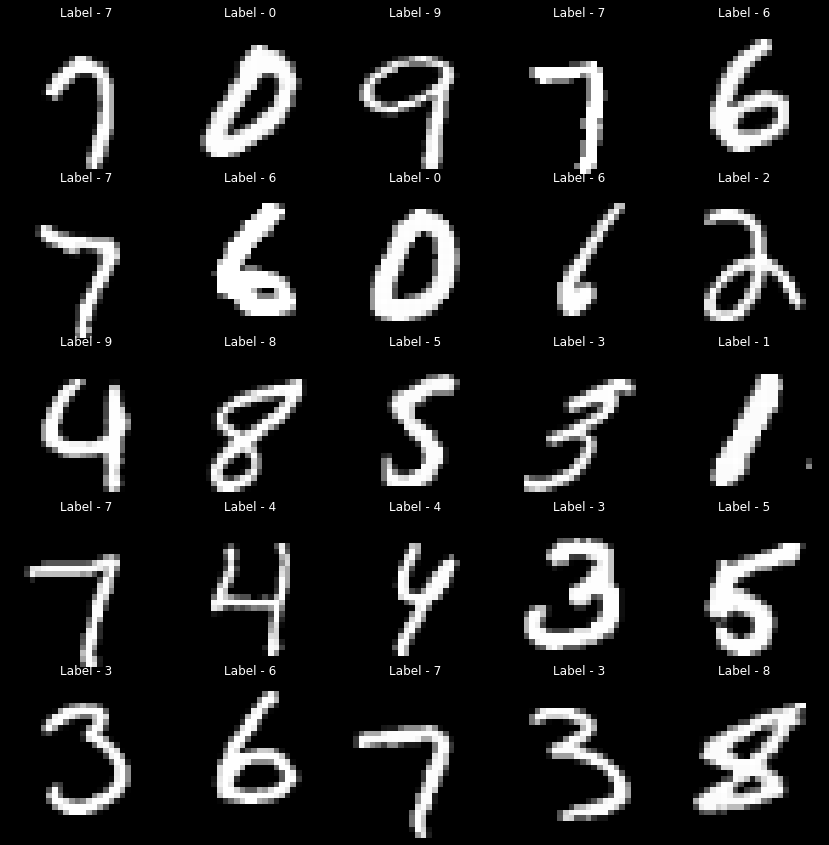

In [4]:
plt.style.use ('dark_background') # Dark mode rocks!!!

# Display random images from the dataset
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 5),
                 axes_pad=0.1)

for ax, idx in zip (grid, torch.randint (0, len (sum_dataset), size=(1, 25))[0]):
    # Get the image and label
    img, _, label, _ = sum_dataset [idx]

    # Display the image with the label
    ax.imshow (img.view (28, 28), cmap='gray')
    ax.set_title (f'Label - {torch.argmax (label)}')
    ax.axis ('off');

### Load the data

In [6]:
# Seed the random generator used by PyTorch
# so that the results are reproduceable
torch.manual_seed(1)

# Define the batch size to be used
# i.e. the number of images to be used per batch
batch_size = 128

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a dataloader 
# Set the batch_size and shuffle to select
# random images for every batch and epoch

# Parameters to be used while loading the data
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = DataLoader (SumDataset (mode='training'),
                           batch_size=batch_size,
                           shuffle=True,
                           **kwargs)

test_loader = DataLoader (SumDataset (mode='validation'),
                           batch_size=batch_size,
                           shuffle=True,
                           **kwargs)

Using downloaded and verified file: ./data/val/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/val/MNIST/raw/train-images-idx3-ubyte.gz to ./data/val/MNIST/raw

Using downloaded and verified file: ./data/val/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/val/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/val/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/val/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/val/MNIST/raw

Processing...
Done!


## Define the network architecture
The architecture should be able to predict the digit using the image from MNIST and calculate the sum of the value predicted with the randomly sampled integer input (from 0-9)


### Approach 1 - Train the model in two stages
- _Stage 1:_ Train a classifier to predict the digits given the image
- _Stage 2:_ Use the trained model from Stage 1, add few Fully Connected layers using the one-hot encoded random number and the one-hot encoded digit predictions to get the sum
    - Make sure that the layers from Stage 1 are set to non-trainable i.e. `requires_grad=False`

#### Stage 1 - Training MNIST

In [7]:
class MNISTNet(nn.Module):
    ''' Define a class initializing the layers constituting the required 
    CNN Architecture and the code for forward pass
    Note: The class extends to the nn.Module, which is a base class for 
    Neural Network modules in PyTorch https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    '''

    def __init__(self):
        ''' Define the layers that constitute the network and
        initialize the base class '''

        # Start by initializing the base class
        super().__init__()
    
        # Define the layers that make up the network
        # i.e. the Network Architecture
        # nn.Conv2d - Used to perform 2-dimensional convolution using the defined size of the kernel
        # nn.MaxPool2d - 2d MaxPooling Layer of the defined size

        # MNIST contains images of size 28x28
        # Since the images are padded, the resultant images after convolution
        # would have the same size
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # Input: 28x28x1; Output: 28x28x32; RF: 3x3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Input: 28x28x32; Output: 28x28x64; RF: 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # Input: 28x28x64; Output: 14x14x64; RF: 10x10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # Input: 14x14x64; Output: 14x14x128; RF: 12x12 
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # Input: 14x14x128; Output: 14x14x256; RF: 14x14 
        self.pool2 = nn.MaxPool2d(2, 2) # Input: 14x14x256; Output: 7x7x256; RF: 24x24
        self.conv5 = nn.Conv2d(256, 512, 3) # Input: 7x7x256; Output: 5x5x512; RF: 26x26
        self.conv6 = nn.Conv2d(512, 1024, 3) # Input: 5x5x512; Output: 3x3x1024; RF: 28x28
        self.conv7 = nn.Conv2d(1024, 10, 3) # Input: 3x3x1024; Output: 1x1x10;

        
    def forward(self, x):
        ''' Define the forward pass
        Each convolution layer is activated using ReLU to add non-linearity
        '''
        # Convolution layer followed by ReLU Activation and then finally a pooling layer
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))

        # Convolution layer followed by ReLU Activation and then finally a pooling layer
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        # Conv followed by activation
        x = F.relu(self.conv6(F.relu(self.conv5(x))))

        # The final layer shouldn't be passed through ReLU, but should be retained
        # as is, before computing the softmax (log)
        #x = F.relu(self.conv7(x))
        x = self.conv7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [8]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
!pip install torchsummary
from torchsummary import summary

# Create a model object
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


##### Train and Validate

In [9]:
# TQDM is just awesome... provides a progress status bar as the training 
# (or any operation) proceeds
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch):
    ''' Define the training steps '''

    # Set the model to training mode
    model.train()

    # Initialize the progress bar
    pbar = tqdm(train_loader)

    # Start iterating through the training data
    for batch_idx, (data, rand_nos, target, results) in enumerate(pbar):
        # Start by converting the data to the required type 
        # (PyTorch CUDA Tensor while using GPU)
        # Convert the target from one-hot encoded vector to an it
        data = data.to(device)
        target = torch.argmax (target, dim=2).flatten ().to(device)

        # Discard/reset the gradients from the previous iteration
        optimizer.zero_grad()

        # Get the predictions for the given data
        output = model(data)

        # Compute the negative loss likelihood of the predictions vs the actuals
        # and propogate the loss backwards (back propogation)
        loss = F.nll_loss(output, target)
        loss.backward()

        # Use the optimizer to take a step in the -ve of the gradient direction
        # by the amount equal to the gradient magnitude times the learning rate 
        optimizer.step()

        # Update the progress bar
        pbar.set_description(desc= f'loss={loss.item():.4f} batch_id={batch_idx}')


def test(model, device, test_loader):
    ''' Validate the trained model on a hold-out set '''

    # Set the model to evalution mode
    model.eval()

    # Initialize the losses
    # and the no of correct predictions to 0
    test_loss = 0
    correct = 0

    # Disable the gradient computations
    # While evaulating only forward pass is used and the backward pass
    # along with the gradient (likewise the gradient update) isn't required
    with torch.no_grad():
        # Iterate over the test/validation set
        for data, rand_nos, target, results in test_loader:
            # Converting the data to the required type 
            # (PyTorch Cuda Tensor while using GPU)
            # Convert the target from one-hot encoded vector to an it
            data = data.to(device)
            target = torch.argmax (target, dim=2).flatten ().to(device)

            # Get the predictions
            output = model(data)

            # Compute the loss against the target
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            # Get the index of the prediction
            # i.e. the output is one-hot encoded, so get the argument with the max
            # log probability
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # Get a count of the correct preditcions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute the final loss on the test/validation data
    test_loss /= len(test_loader.dataset)

    # Display the results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
# Initialize the model instance
model = MNISTNet().to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Set the epochs
epochs = 10

# Train the model for epochs no. of times
for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    train(model, device, train_loader, optimizer, epoch)

    # Validate the results on the test/validation set
    test(model, device, test_loader)

    print ('\n')

  0%|          | 0/469 [00:00<?, ?it/s]

Iteration 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0557, Accuracy: 9818/10000 (98.18%)



Iteration 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9890/10000 (98.90%)



Iteration 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9901/10000 (99.01%)



Iteration 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9909/10000 (99.09%)



Iteration 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9900/10000 (99.00%)



Iteration 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9914/10000 (99.14%)



Iteration 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9915/10000 (99.15%)



Iteration 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9920/10000 (99.20%)



Iteration 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9915/10000 (99.15%)



Iteration 10


loss=0.0046 batch_id=468: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0265, Accuracy: 9931/10000 (99.31%)





#### Stage 2 - Training to calculate the sum

In [11]:
class SumNet (nn.Module):
    ''' Compute the sum of the predicted digit and the random integer '''

    def __init__(self, digit_network=None):
        ''' Define the layers of the network and initialize the base class '''

        # Start by initializing the base class
        super ().__init__ ()

        # Set the mode of operation
        self.mode = 'training' # or 'validation'

        # Check if the base network is passed
        assert digit_network != None, \
            'Digit network has to be passed, please train to predict digits'

        # Use the already trained network to get predictions on the input digit
        self.digit_network = digit_network

        # Disable gradient for all the layers in the base network
        for layer in self.digit_network.parameters ():
            layer.requires_grad = False

        # Define the fully connected layers to calculate the sum
        # This is over-kill for addition of two number both between 0-9
        self.hidden_sum1 = nn.Linear (in_features=10+10, out_features=1000)
        self.hidden_sum2 = nn.Linear (in_features=1000, out_features=100)
        self.final_sum = nn.Linear (in_features=100, out_features=19)


    def forward(self, x1, x2):
        ''' Forward pass through the layers to calculate the sum 
        
        Parameters:
            x1 - One-hot encoded digit (while training the labels are used;
                    while validating, the predictions from the above trainined model is used)
            x2 - One-hot encoded randomly generated integer
        '''

        # Pass the predictions along with the randint to the fc layers
        x = torch.cat ([x1.view (-1, 10), x2.view (-1, 10)], dim=1)
        x = F.relu (self.hidden_sum1 (x))
        x = F.dropout (x, p=0.5, training=True if self.mode=='training' else False)
        x = F.relu (self.hidden_sum2 (x))
        x = F.dropout (x, p=0.5, training=True if self.mode=='training' else False)
        x = self.final_sum (x)
        
        x = x.view(-1, 19)
        return F.log_softmax(x)

In [12]:
# Create a model object
sum_model = SumNet(model).to(device)
summary(sum_model, input_size=[(1, 10), (1, 10)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]          21,000
            Linear-2                  [-1, 100]         100,100
            Linear-3                   [-1, 19]           1,919
Total params: 123,019
Trainable params: 123,019
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.47
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**Note:** The error above (if any) is only in torch summary as seen in this [issue](https://github.com/sksq96/pytorch-summary/issues/90)

##### Train and Validate

In [13]:
# TQDM is just awesome... provides a progress status bar as the training 
# (or any operation) proceeds
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch):
    ''' Define the training steps '''

    # Set the model to training mode
    model.train()
    model.mode = 'training'

    # Initialize the progress bar
    pbar = tqdm(train_loader)

    # Start iterating through the training data
    for batch_idx, (data, rand_nos, target, results) in enumerate(pbar):
        # Start by converting the data to the required type 
        # (PyTorch CUDA Tensor while using GPU)
        # Convert the target from one-hot encoded vector to an int
        data = data.to(device)
        target = target.type(torch.FloatTensor).to(device) # Used as input
        rand_nos = rand_nos.to(device) # Used as input
        results = torch.argmax (results, dim=2).flatten ().to(device)

        # Discard/reset the gradients from the previous iteration
        optimizer.zero_grad()

        # Get the predictions
        output = model(target, rand_nos)

        # Compute the negative loss likelihood of the predictions vs the actuals
        # and propogate the loss backwards (back propogation)
        loss = F.nll_loss(output, results)
        loss.backward()

        # Use the optimizer to take a step in the -ve of the gradient direction
        # by the amount equal to the gradient magnitude times the learning rate 
        optimizer.step()

        # Update the progress bar
        pbar.set_description(desc= f'loss={loss.item():.4f} batch_id={batch_idx}')


def test(digit_model, model, device, test_loader):
    ''' Validate the trained model on a hold-out set '''

    # Set the model to evalution mode
    model.eval()
    model.mode = 'validation'

    # Initialize the losses
    # and the no of correct predictions to 0
    test_loss = 0
    correct = 0

    # Disable the gradient computations
    # While evaulating only forward pass is used and the backward pass
    # along with the gradient (likewise the gradient update) isn't required
    with torch.no_grad():
        # Iterate over the test/validation set
        for data, rand_nos, target, results in test_loader:
            # Converting the data to the required type 
            # (PyTorch Cuda Tensor while using GPU)
            # Convert the target from one-hot encoded vector to an it
            data = data.to(device)
            target = torch.argmax (target, dim=2).flatten ().to(device)
            rand_nos = rand_nos.to(device)
            results = torch.argmax (results, dim=2).flatten ().to(device)

            # Get the predictions, and convert into a onehot encoded vector
            digit_pred = digit_model (data)
            digit_pred = digit_pred.argmax (dim=1, keepdim=True).flatten ()
            digit_pred = F.one_hot (digit_pred, num_classes=10)
            digit_pred = digit_pred.type (torch.FloatTensor).to(device)

            # Get the results for the sum model
            output = model(digit_pred, rand_nos)

            # Compute the loss against the target
            test_loss += F.nll_loss(output, results, reduction='sum').item()  # sum up batch loss

            # Get the index of the prediction
            # i.e. the output is one-hot encoded, so get the argument with the max
            # log probability
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # Get a count of the correct preditcions
            correct += pred.eq(results.view_as(pred)).sum().item()

    # Compute the final loss on the test/validation data
    test_loss /= len(test_loader.dataset)

    # Display the results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
# Initialize the model instance
sum_model = SumNet(model).to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 
optimizer = optim.SGD(sum_model.parameters(), lr=0.01, momentum=0.9)

# Set the epochs
epochs = 5

# Train the model for epochs no. of times
for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    train(sum_model, device, train_loader, optimizer, epoch)

    # Validate the results on the test/validation set
    test(model, sum_model, device, test_loader)

    print ('\n\n')

  0%|          | 0/469 [00:00<?, ?it/s]

Iteration 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=1.4728 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 1.1869, Accuracy: 9118/10000 (91.18%)




Iteration 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2108, Accuracy: 9931/10000 (99.31%)




Iteration 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0939, Accuracy: 9931/10000 (99.31%)




Iteration 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0829, Accuracy: 9931/10000 (99.31%)




Iteration 5


loss=0.0607 batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]



Test set: Average loss: 0.0810, Accuracy: 9931/10000 (99.31%)






#### Visualize the results
The results from Model 1 (i.e. to predict the handwritten digit) was about 99.3 at best and the final model with the sum calculation is similar at 99.31

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


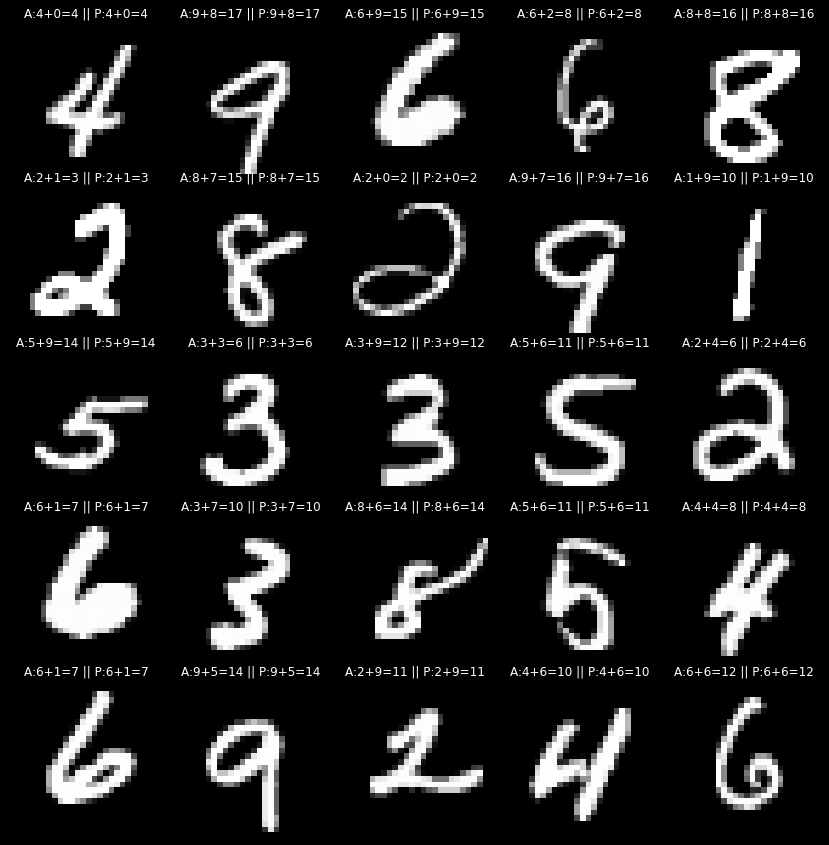

In [15]:
# Display sample results from the test set
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, 
                nrows_ncols=(5, 5),
                axes_pad=0.1)

for ax, batch in zip (grid, test_loader):
    # Get a random index
    idx = torch.randint (low=0, high=batch_size, size=(1,)) [0]
    
    # Get the image and label
    img, rand_no, label, result = batch [0][idx], batch [1][idx], batch [2][idx], batch [3][idx]
    
    # Get predictions
    digit_pred = model(img.view (-1, 1, 28, 28).to (device))
    digit_pred = digit_pred.argmax (dim=1, keepdim=True).flatten ()
    digit_pred = F.one_hot (digit_pred, num_classes=10)

    # Get the results for the sum model
    output = sum_model(digit_pred.type (torch.FloatTensor).to (device), rand_no.to (device))

    # Display the image with the label
    ax.imshow (img.view (28, 28), cmap='gray')
    ax.set_title (f'A:{torch.argmax(label)}+{torch.argmax(rand_no)}={torch.argmax(result)} || ' +\
                  f'P:{torch.argmax(digit_pred)}+{torch.argmax(rand_no)}={torch.argmax(output)}')
    ax.axis ('off');

#### Combine the two stages

In [16]:
class MNIST_SumNet (nn.Module):
    ''' Given an input image of a handwritten digit and a random integer (between
    0-9), the model will return the predicted digit and the sum of the int and the digit '''

    def __init__(self, mnist_model, sum_model):
        ''' Initiaize with the trained models 
        
        Parameters:
            mnist_model - Model trained on MNIST
            sum_model - Model trained to predict the sum
        '''
        # Initialize the super class
        super ().__init__ ()
        
        # Trained on MNIST
        self.mnist_model = mnist_model

        # Trained to get the sum of two ints (0-9)
        self.sum_model = sum_model


    def forward (self, img, number):
        ''' Predict the digit and calculate the sum during the forward pass 
        
        Parameters:
            img - Image of a digit (of size 28x28 each)
            number - Any integer between 0 and 9 (inclusive)
        '''

        # Set the device to either cpu or gpu
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Predict the digit and one-hot encode the result to be passed 
        # to get the sum
        digit_pred = self.mnist_model (img.view (-1, 1, 28, 28).to (device))
        digit_pred = digit_pred.argmax (dim=1, keepdim=True).flatten ()
        digit_pred = F.one_hot (digit_pred, num_classes=10)

        # Get the results for the sum model
        output = sum_model(digit_pred.type (torch.FloatTensor).to (device), rand_no.to (device))
        
        # Return the predicted digit and the sum
        return digit_pred, output 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


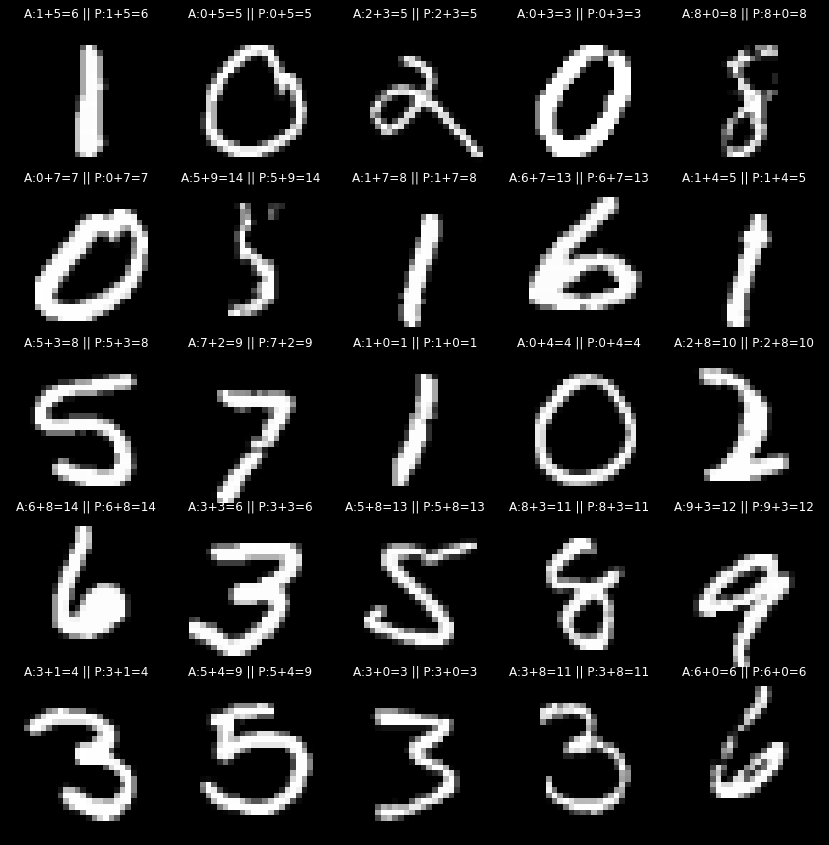

In [17]:
# Display sample results from the test set
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, 
                nrows_ncols=(5, 5),
                axes_pad=0.1)

# Create an object of the Network Class
mnist_sum = MNIST_SumNet (mnist_model=model, sum_model=sum_model)

# Iterate over a few samples
for ax, batch in zip (grid, test_loader):
    # Get a random index
    idx = torch.randint (low=0, high=batch_size, size=(1,)) [0]

    # Get the image and label
    img, rand_no, label, result = batch [0][idx], batch [1][idx], batch [2][idx], batch [3][idx]

    # Get the predicted digit and the sum
    digit_pred, output = mnist_sum (img, rand_no)

    # Display the image with the label
    ax.imshow (img.view (28, 28), cmap='gray')
    ax.set_title (f'A:{torch.argmax(label)}+{torch.argmax(rand_no)}={torch.argmax(result)} || ' +\
                  f'P:{torch.argmax(digit_pred)}+{torch.argmax(rand_no)}={torch.argmax(output)}')
    ax.axis ('off');